# Feature Engineering

##### Importación de librerías

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import re

##### Configuración de visualización

In [4]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

##### Carga de dataset

In [ ]:
csv_ubi = Path("../data/Titanic-Dataset-Canvas.csv")
df = pd.read_csv(csv_ubi)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Feature 1 - Título (Title)
Los títulos en los nombres reflejan estatus social, estado civil y edad aproximada.

In [12]:
def extract_title(name):
    if not isinstance(name, str):
        return "Unknown"

    match = re.search(r', \s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    return match.group(1).strip()

all_titles = df['Name'].apply(extract_title).unique()
print("Títulos únicos encontrados en el dataset:")
print(sorted(all_titles))

def create_title_mapping(titles):
    main_titles = {"Mr", "Mrs", "Miss", "Master"}
    
    variations = {
        "Mlle": "Miss",
        "Ms": "Miss",
        "Mme": "Mrs",
    }

    title_mapping = {}

    for title in titles:
        if title in main_titles:
            title_mapping[title] = title
        elif title in variations:
            title_mapping[title] = variations[title]
        else: title_mapping[title] = "Rare"

    return title_mapping

title_mapping = create_title_mapping(all_titles)
print("\nMapeo generado automáticamente:")
for original, mapped in sorted(title_mapping.items()):
    print(f"'{original}' -> '{mapped}'")

Títulos únicos encontrados en el dataset:
['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']

Mapeo generado automáticamente:
'Capt' -> 'Rare'
'Col' -> 'Rare'
'Don' -> 'Rare'
'Dr' -> 'Rare'
'Jonkheer' -> 'Rare'
'Lady' -> 'Rare'
'Major' -> 'Rare'
'Master' -> 'Master'
'Miss' -> 'Miss'
'Mlle' -> 'Miss'
'Mme' -> 'Mrs'
'Mr' -> 'Mr'
'Mrs' -> 'Mrs'
'Ms' -> 'Miss'
'Rev' -> 'Rare'
'Sir' -> 'Rare'
'the Countess' -> 'Rare'


In [13]:
def extract_and_map_title(name, mapping):
    if not isinstance(name, str):
        return "Unknown"
    
    match = re.search(r',\s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    title = match.group(1).strip()
    return mapping.get(title, "Rare")
df['Title'] = df['Name'].apply(lambda x: extract_and_map_title(x, title_mapping))

print("Distribución final de títulos:")
print(df['Title'].value_counts())

Distribución final de títulos:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


##### Feature 2: Tamaño de la familia (Family Size)

El tamaño de la familia puede influir en la supervivencia, ya que las familias más grandes pueden tener patrones diferentes de supervivencia.

=== ANÁLISIS DE FEATURE: FAMILY SIZE ===
Rango: 1 - 11
Distribución:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

Tasa de supervivencia por tamaño de familia:
            Count  Survival_Rate
FamilySize                      
1             537          0.304
2             161          0.553
3             102          0.578
4              29          0.724
5              15          0.200
6              22          0.136
7              12          0.333
8               6          0.000
11              7          0.000


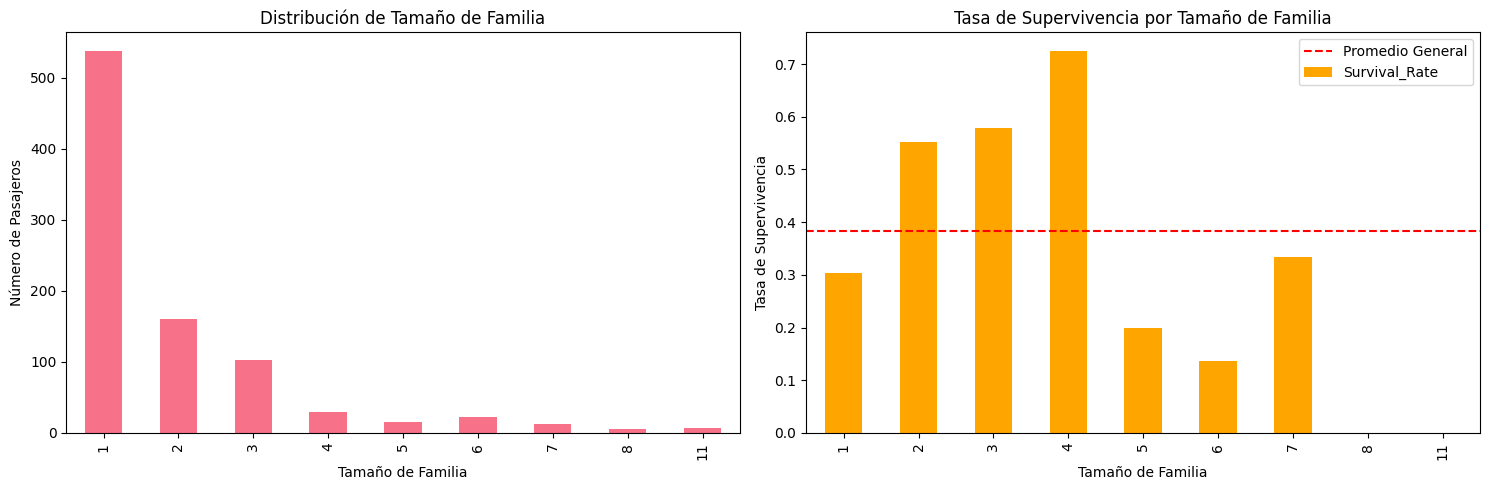

In [14]:
def compute_family_size(sibsp, parch):
    try:
        return int(sibsp) + int(parch) + 1
    except (ValueError, TypeError):
        s = pd.to_numeric(pd.Series([sibsp]), errors='coerce').iloc[0]
        p = pd.to_numeric(pd.Series([parch]), errors='coerce').iloc[0]
        s = 0 if pd.isna(s) else int(s)
        p = 0 if pd.isna(p) else int(p)
        return s + p + 1

df['FamilySize'] = [compute_family_size(s, p) for s, p in zip(df['SibSp'], df['Parch'])]

print("=== ANÁLISIS DE FEATURE: FAMILY SIZE ===")
print(f"Rango: {df['FamilySize'].min()} - {df['FamilySize'].max()}")
print(f"Distribución:")
family_counts = df['FamilySize'].value_counts().sort_index()
print(family_counts)

if 'Survived' in df.columns:
    survival_by_family = df.groupby('FamilySize')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_family.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por tamaño de familia:")
    print(survival_by_family)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    family_counts.plot(kind='bar', ax=ax1)
    ax1.set_title('Distribución de Tamaño de Familia')
    ax1.set_xlabel('Tamaño de Familia')
    ax1.set_ylabel('Número de Pasajeros')

    survival_by_family['Survival_Rate'].plot(kind='bar', ax=ax2, color='orange')
    ax2.set_title('Tasa de Supervivencia por Tamaño de Familia')
    ax2.set_xlabel('Tamaño de Familia')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

##### Feature 3: Viajero solo (isAlone)
Personas que viajan solas igualmente pueden tener diferentes patrones de supervivencia, y pueden ser más vulnerables en situaciones de emergencia.

=== ANÁLISIS DE FEATURE: IS ALONE ===
Distribución:
Viajan acompañados (0): 354
Viajan solos (1): 537
Porcentaje que viaja solo: 60.3%

Tasa de supervivencia por tipo de viaje:
            Count  Survival_Rate
Acompañado    354          0.506
Solo          537          0.304


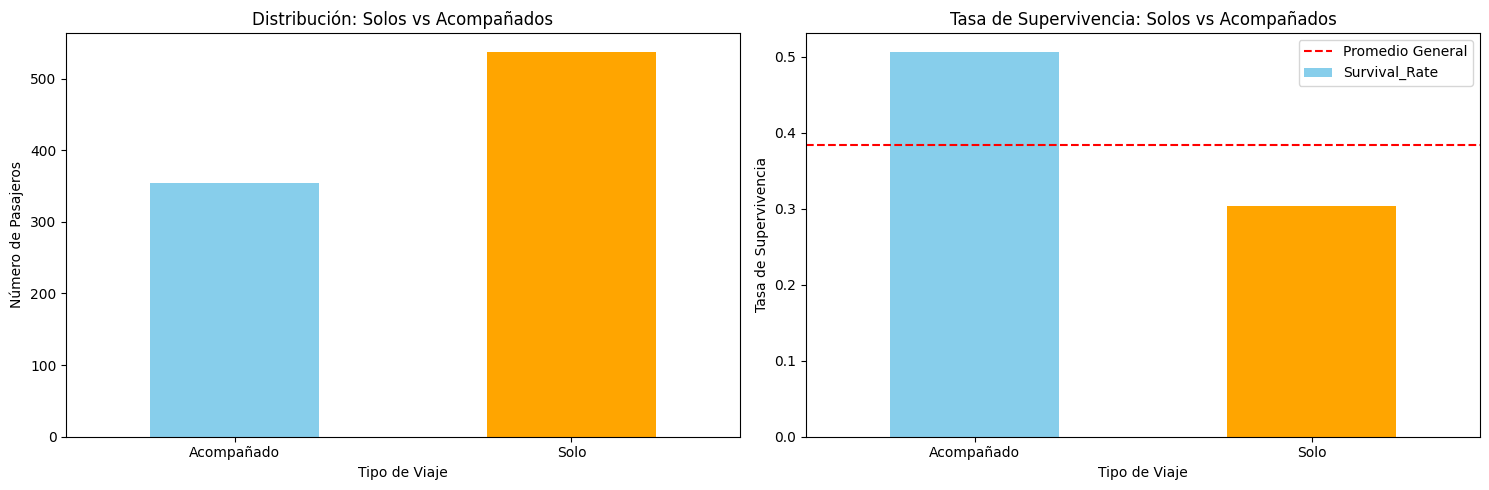


Verificación cruzada con FamilySize:
IsAlone       0    1  All
FamilySize               
1             0  537  537
2           161    0  161
3           102    0  102
4            29    0   29
5            15    0   15
6            22    0   22
7            12    0   12
8             6    0    6
11            7    0    7
All         354  537  891


In [15]:
def compute_is_alone(family_size):
    try:
        return 1 if int(family_size) == 1 else 0
    except (ValueError, TypeError):
        return 0

df['IsAlone'] = df['FamilySize'].apply(compute_is_alone)

print("=== ANÁLISIS DE FEATURE: IS ALONE ===")
print(f"Distribución:")
alone_counts = df['IsAlone'].value_counts().sort_index()
print(f"Viajan acompañados (0): {alone_counts[0]}")
print(f"Viajan solos (1): {alone_counts[1]}")
print(f"Porcentaje que viaja solo: {(alone_counts[1] / len(df)) * 100:.1f}%")

if 'Survived' in df.columns:
    survival_by_alone = df.groupby('IsAlone')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_alone.columns = ['Count', 'Survival_Rate']
    survival_by_alone.index = ['Acompañado', 'Solo']
    print(f"\nTasa de supervivencia por tipo de viaje:")
    print(survival_by_alone)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    alone_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'orange'])
    ax1.set_title('Distribución: Solos vs Acompañados')
    ax1.set_xlabel('Tipo de Viaje')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.set_xticklabels(['Acompañado', 'Solo'], rotation=0)

    survival_by_alone['Survival_Rate'].plot(kind='bar', ax=ax2, color=['skyblue', 'orange'])
    ax2.set_title('Tasa de Supervivencia: Solos vs Acompañados')
    ax2.set_xlabel('Tipo de Viaje')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.set_xticklabels(['Acompañado', 'Solo'], rotation=0)
    
    plt.tight_layout()
    plt.show()

print(f"\nVerificación cruzada con FamilySize:")
cross_check = pd.crosstab(df['FamilySize'], df['IsAlone'], margins=True)
print(cross_check)